In [1]:
pip install numpy pandas scikit-learn pyro-ppl causalml econml pgmpy dowhy

In [2]:
#Load the librarys
import numpy as np
import pandas as pd
import seaborn as sns #Graph library that use matplot in background
import matplotlib.pyplot as plt #to plot some parameters in seaborn
from sklearn.model_selection import train_test_split
#from causalml.inference.tree import CausalForest
from dowhy import CausalModel
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator
from econml.dml import CausalForestDML
from pyro.infer import SVI, Trace_ELBO
import pyro.distributions as dist
import pyro
import torch

In [3]:
from dowhy import gcm

In [4]:
import networkx as nx

In [5]:
# Important Libraries

import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

# Step 1: Data Engineering


In [6]:
# @title Importing the Data
# The raw link to the CSV file in the GitHub repository
url = 'https://raw.githubusercontent.com/dzrich/PhD_Research_in_CausalML/main/Data/CreditRiskDataset.csv'

# Load the CSV file into a pandas DataFrame
CreditRiskDataset = pd.read_csv(url)

# Display the first few rows of the dataset
print(CreditRiskDataset.head())

   person_age  person_income person_home_ownership  person_emp_length  \
0          22          59000                  RENT              123.0   
1          21           9600                   OWN                5.0   
2          25           9600              MORTGAGE                1.0   
3          23          65500                  RENT                4.0   
4          24          54400                  RENT                8.0   

  loan_intent loan_grade  loan_amnt  loan_int_rate  loan_status  \
0    PERSONAL          D      35000          16.02            1   
1   EDUCATION          B       1000          11.14            0   
2     MEDICAL          C       5500          12.87            1   
3     MEDICAL          C      35000          15.23            1   
4     MEDICAL          C      35000          14.27            1   

   loan_percent_income cb_person_default_on_file  cb_person_cred_hist_length  \
0                 0.59                         Y                           3  

## First Look at the data:
Looking the Type of Data
Null Numbers
Unique values
The first rows of our dataset


In [7]:
#Searching for Missings,type of data and also know the shape of data
print(CreditRiskDataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
 12  OTHER_DEBT                  32581 non-null  float64
 13  TIME_WITH_BANK              325

#### Drop unwanted Columns

In [8]:
df = CreditRiskDataset.drop(['Unnamed: 15','Unnamed: 16'], axis=1)

#### Impute missing values

In [9]:
df['person_emp_length'] = df['person_emp_length'].fillna(df['person_emp_length'].mean())
df['loan_int_rate'] = df['loan_int_rate'].fillna(df['loan_int_rate'].mean())

In [10]:
df["person_emp_length"].fillna((df["person_emp_length"].median()), inplace = True)
df["loan_int_rate"].fillna((df["loan_int_rate"].mean()), inplace = True)
#check
df["loan_int_rate"].isnull().sum()

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.




0

# Perfom Some explorations:
 - Starting by distribuition of column Age.
 - Some Seaborn graphical
 - Columns crossing

**Let's start looking through target variable and their distribuition

Text(0.5, 0, 'Default Status')

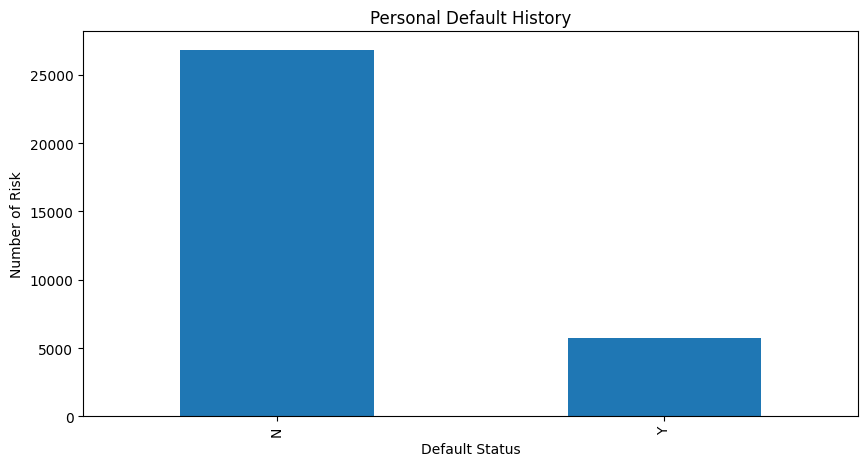

In [11]:
df.cb_person_default_on_file.value_counts().plot(kind='bar', figsize =(10,5))
plt.title("Personal Default History")
plt.ylabel('Number of Risk')
plt.xlabel('Default Status')

In [12]:
df_good = df.loc[df["cb_person_default_on_file"] == 'N']['person_age'].values.tolist()
df_bad = df.loc[df["cb_person_default_on_file"] == 'Y']['person_age'].values.tolist()
df_age = df['person_age'].values.tolist()

Text(0.5, 0, 'Age')

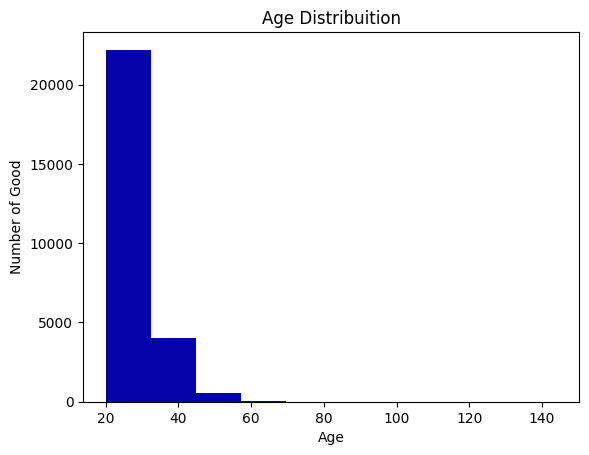

In [13]:
trace0 = plt.hist( x= df_good,bins=None,range=None,density=False,weights=None,
    cumulative=False,bottom=None,histtype='bar',align='mid',orientation='vertical',
    rwidth=None,log=False,color='#0504aa',label='N',stacked=False)
plt.title("Age Distribuition")
plt.ylabel('Number of Good')
plt.xlabel('Age')

Text(0.5, 0, 'Age')

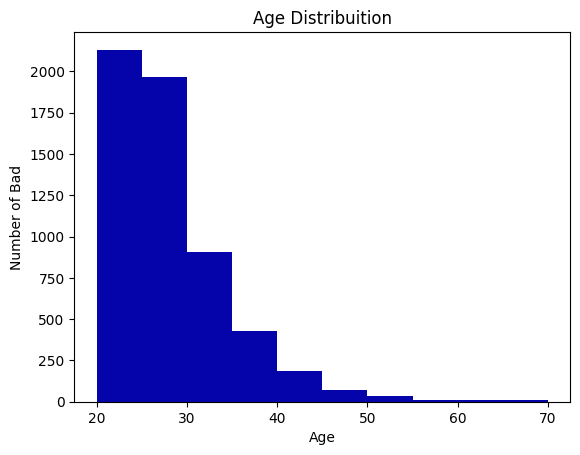

In [14]:
trace1 = plt.hist(x=df_bad,bins=None,range=None,density=False,weights=None,
    cumulative=False,bottom=None,histtype='bar',align='mid',orientation='vertical',
    rwidth=None,log=False,color='#0504aa',label='Good',stacked=False)
plt.title("Age Distribuition")
plt.ylabel('Number of Bad')
plt.xlabel('Age')

Text(0.5, 0, 'Age')

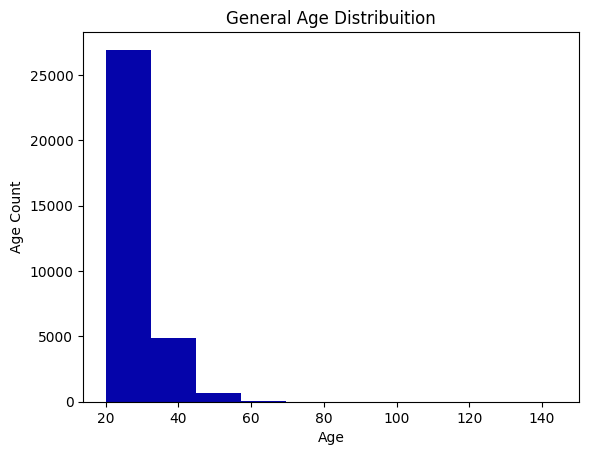

In [15]:
trace2 = plt.hist(x=df_age,bins=None,range=None,density=False,weights=None,
    cumulative=False,bottom=None,histtype='bar',align='mid',orientation='vertical',
    rwidth=None,log=False,color='#0504aa',label='Good',stacked=False)
plt.title("General Age Distribuition")
plt.ylabel('Age Count')
plt.xlabel('Age')

In [16]:
df_good = df[df["cb_person_default_on_file"] == 'N']
df_bad = df[df["cb_person_default_on_file"] == 'Y']

## Encoding the Independent Variable
Use two classes: First, The column transform the classes from the compose module of Sklearn library. Second, the OHE class module for preprocessing from the Sklearn library

In [17]:
df = pd.get_dummies(df, columns=['person_home_ownership'],dtype= float)
df = pd.get_dummies(df, columns=['loan_intent'],dtype= float)
df = pd.get_dummies(df, columns=['loan_grade'],dtype= float)
df = pd.get_dummies(df, columns=['cb_person_default_on_file'],dtype= float)

## Correlation:

**Looking at the correlation of the data**

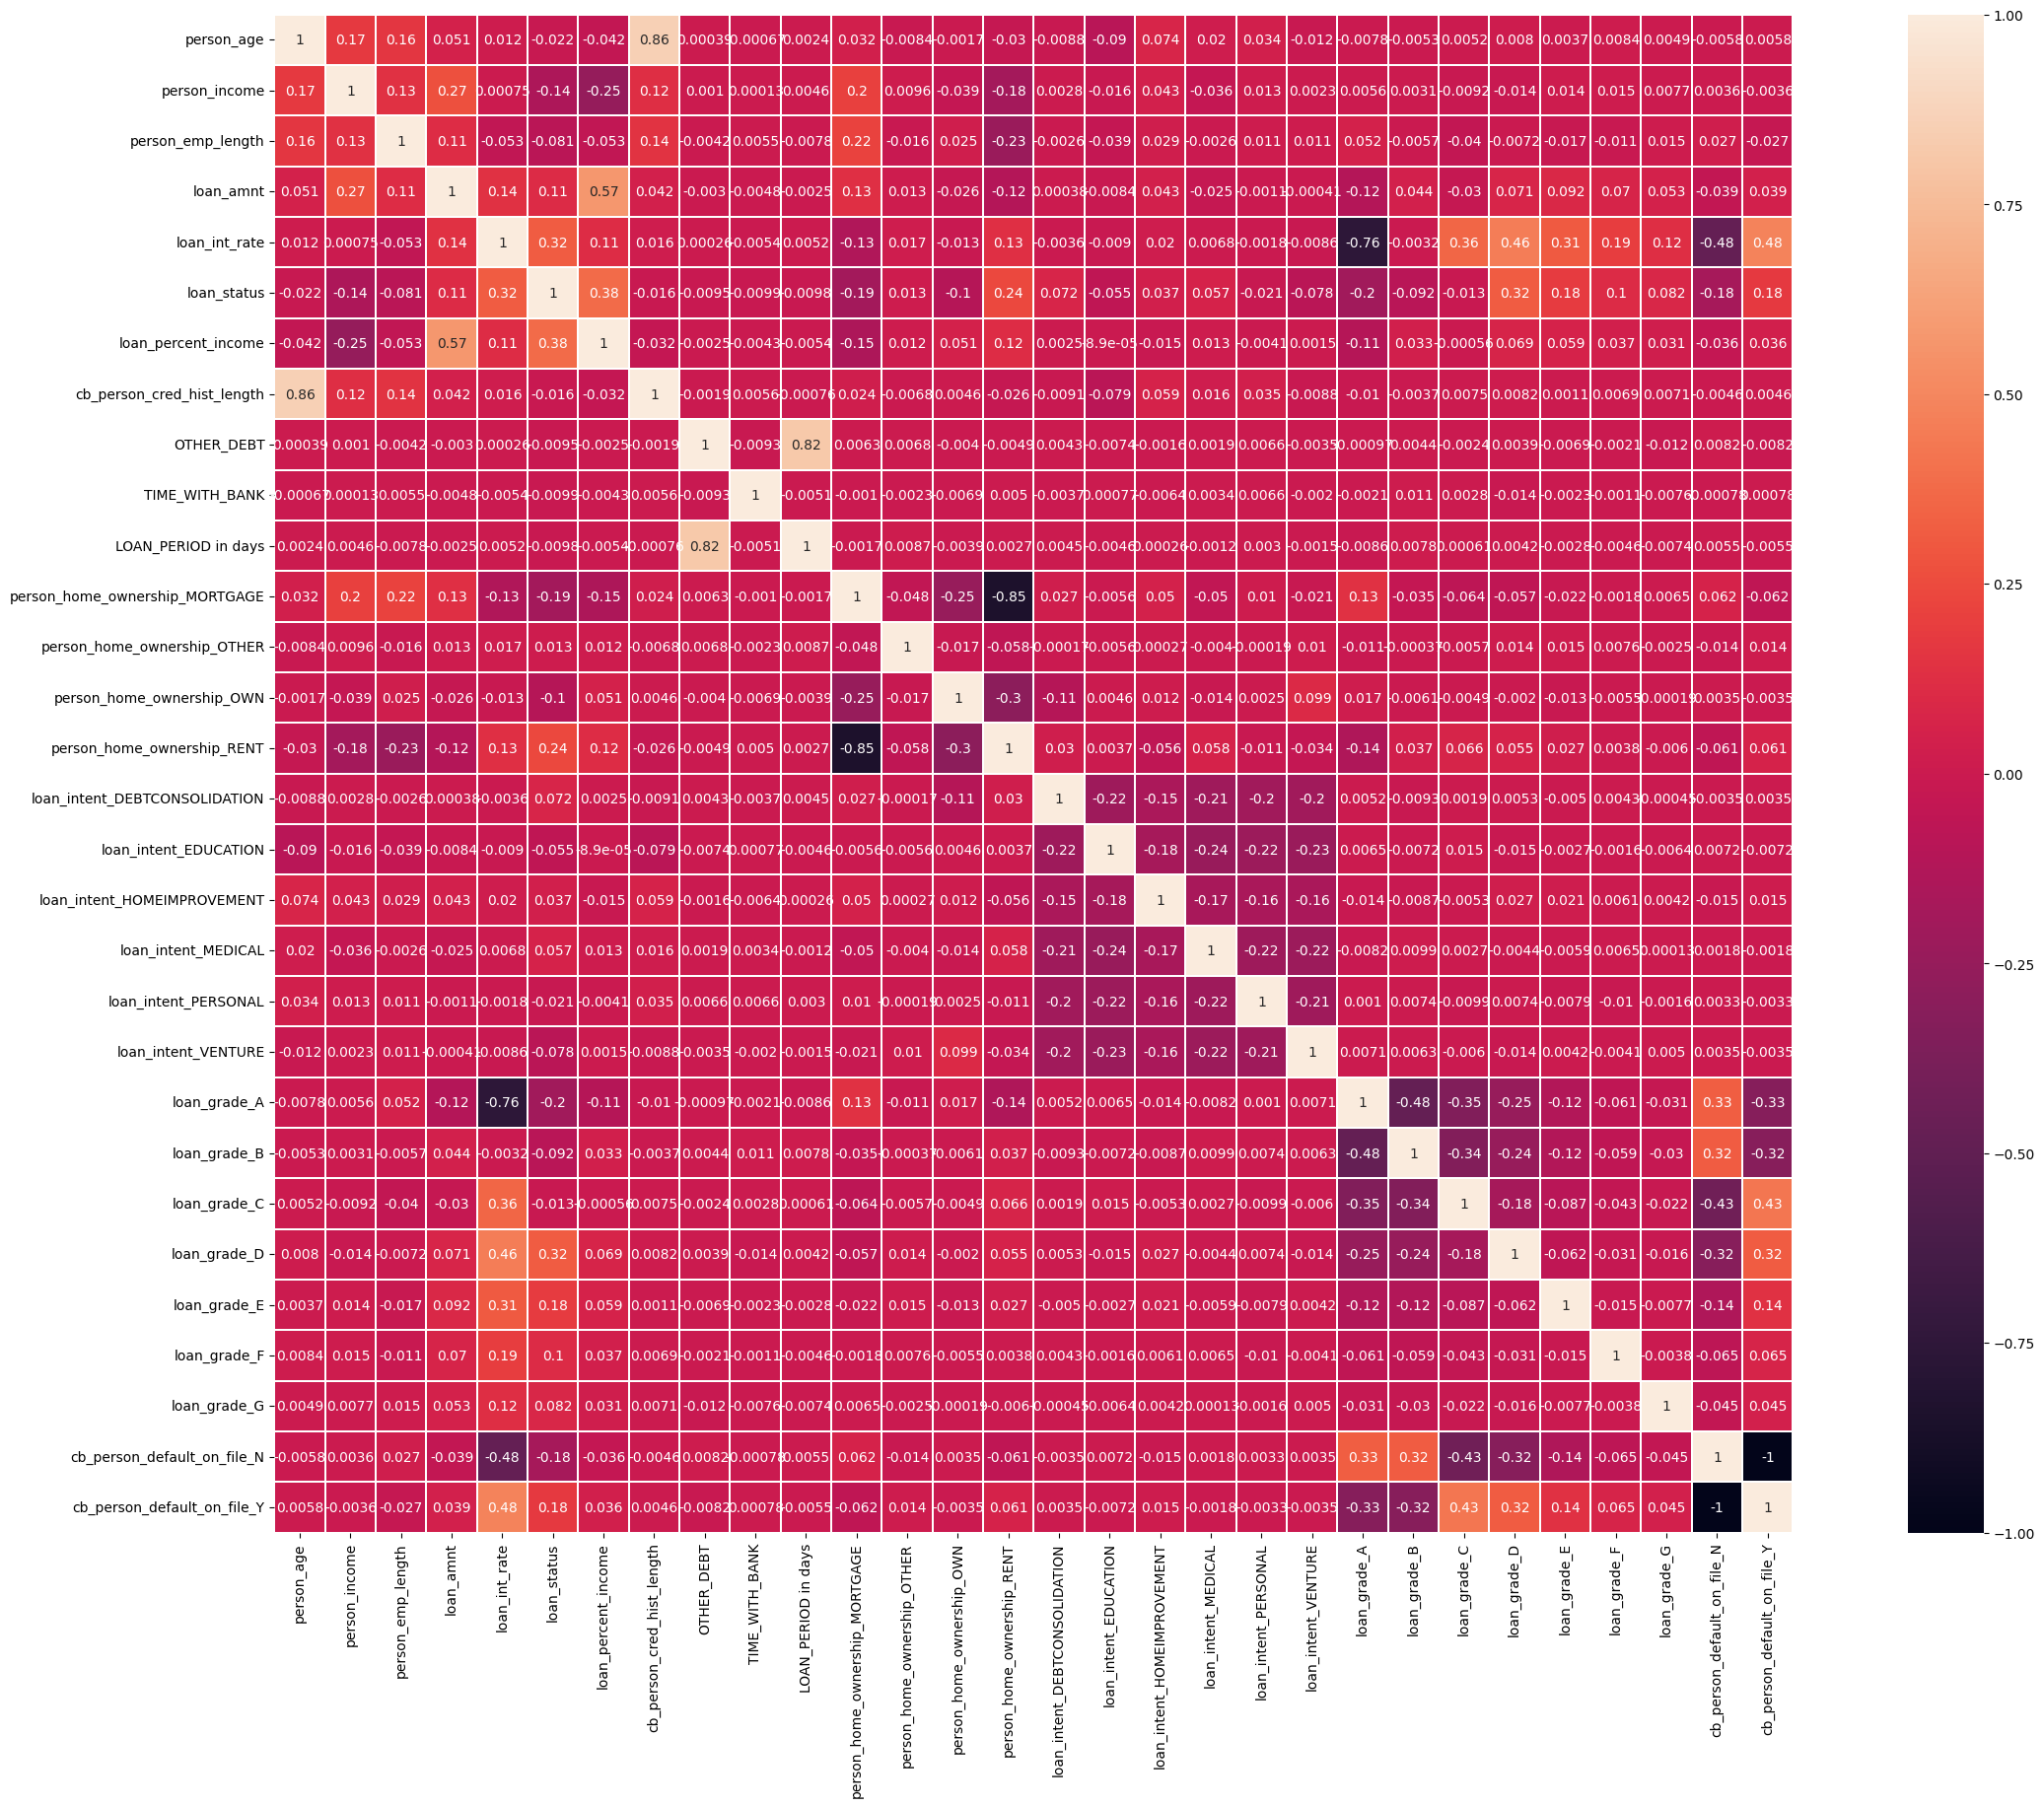

In [18]:
plt.figure(figsize=(30,20))
sns.heatmap(df.astype(float).corr(),linewidths=0.1,vmax=1.0,
            square=True,  linecolor='white', annot=True)
plt.show()

In [19]:
df=df.drop(['cb_person_default_on_file_Y'], axis=1)

In [20]:
df.head()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length,OTHER_DEBT,TIME_WITH_BANK,...,loan_intent_PERSONAL,loan_intent_VENTURE,loan_grade_A,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,cb_person_default_on_file_N
0,22,59000,123.0,35000,16.02,1,0.59,3,31681.020000,7,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,21,9600,5.0,1000,11.14,0,0.10,2,31437.140180,6,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,25,9600,1.0,5500,12.87,1,0.57,3,23979.127160,9,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,23,65500,4.0,35000,15.23,1,0.53,2,2602.283057,5,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,24,54400,8.0,35000,14.27,1,0.55,4,59393.203400,8,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


## Preprocessing:
Importing ML librarys
Setting X and y variables to the prediction
Splitting Data

In [21]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score # to split the data
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, fbeta_score #To evaluate our model

from sklearn.model_selection import GridSearchCV

# Algorithmns models to be compared
from sklearn.linear_model import LogisticRegression


In [22]:
df['loan_amnt'] = np.log(df['loan_amnt'])# Transforming 'loan amount ' and 'person_income' columns
df['person_income'] = np.log(df['person_income'])

## Splitting the dataset into the Training set and Test set

In [23]:
#Creating the X and y variables
X = df.drop('cb_person_default_on_file_N', axis = 1).values
y = df['cb_person_default_on_file_N'].values

# Spliting X and y into train and test version
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42)

## Feature Scaling

In [24]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [25]:
print(X_train)

[[-0.2746665   2.26064696  1.28731712 ... -0.17160693 -0.08566264
  -0.0443651 ]
 [ 0.50686454  0.26030224 -0.4394184  ... -0.17160693 -0.08566264
  -0.0443651 ]
 [-0.89989133 -1.61421283  0.05393461 ... -0.17160693 -0.08566264
  -0.0443651 ]
 ...
 [-0.2746665   1.72812048 -0.9327714  ...  5.82727051 -0.08566264
  -0.0443651 ]
 [-0.2746665   2.02399569 -1.17944791 ... -0.17160693 -0.08566264
  -0.0443651 ]
 [-0.11836029  0.27530586  1.53399362 ... -0.17160693 -0.08566264
  -0.0443651 ]]


## Training the Logistic Regression model on the Training set

In [26]:
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier(random_state = 0)
#classifier.fit(X_train, y_train)

In [27]:
classifier.fit(X_train, y_train)

DecisionTreeClassifier(random_state=0)

## Predicting the Test set results

In [28]:
y_pred = classifier.predict(X_test)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

[[1. 1.]
 [1. 0.]
 [0. 1.]
 ...
 [1. 1.]
 [1. 1.]
 [1. 1.]]


In [29]:
from sklearn.metrics import confusion_matrix, accuracy_score
#cm = confusion_matrix(y_test, y_pred)
print(pd.crosstab(y_test, y_pred, rownames = ['Actual'], colnames = ['Predicted']))
#print(cm)

print(accuracy_score(y_test, y_pred))

Predicted  0.0   1.0
Actual              
0.0        738   753
1.0        722  5933
0.8189295359685735


In [30]:
y_pred = classifier.predict(X_test)

print(accuracy_score(y_test,y_pred))
print("\n")
print(confusion_matrix(y_test, y_pred))
print("\n")
print(classification_report(y_test, y_pred))

0.8189295359685735


[[ 738  753]
 [ 722 5933]]


              precision    recall  f1-score   support

         0.0       0.51      0.49      0.50      1491
         1.0       0.89      0.89      0.89      6655

    accuracy                           0.82      8146
   macro avg       0.70      0.69      0.69      8146
weighted avg       0.82      0.82      0.82      8146



## ROC Curve

In [31]:
from sklearn.metrics import roc_curve, roc_auc_score
roc_curve(y_test, y_pred)

(array([0.        , 0.50503018, 1.        ]),
 array([0.        , 0.89151014, 1.        ]),
 array([inf,  1.,  0.]))

In [32]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

Text(0.5, 1.0, 'ROC curve')

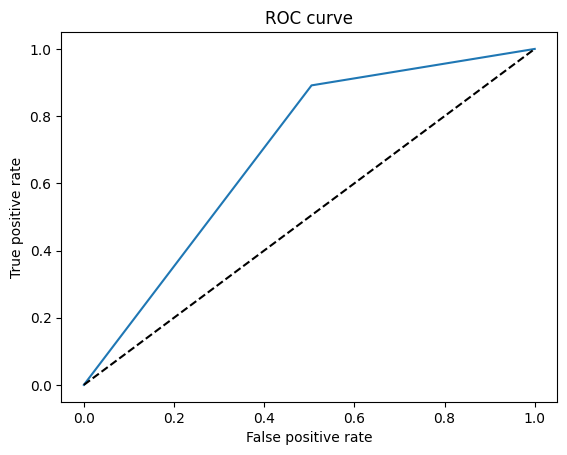

In [33]:
plt.plot(fpr, tpr)
plt.plot(fpr, fpr, linestyle = '--', color = 'k')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')

# Overfitting & regularization
In order to avoid overfitting, it is necessary to use additional techniques **(e.g. cross-validation, regularization, early stopping, pruning, or Bayesian priors).**


#### Regularization
is a way of finding a good **bias-variance tradeoff** by tuning the complexity of the model. It is a very useful method to handle:
 - collinearity (high correlation among features),
 - filter out noise from data, and
 - eventually prevent overfitting.
**The concept behind regularization is to introduce additional information (bias) to penalize extreme parameter weights.**

## k-fold cross-validation

The k-fold cross-validation procedure is a standard method for estimating the performance of a machine learning algorithm or configuration on a dataset.

A single run of the k-fold cross-validation procedure may result in a noisy estimate of model performance. Different splits of the data may result in very different results.

It is common to evaluate machine learning models on a dataset using k-fold cross-validation.

The k-fold cross-validation procedure divides a limited dataset into k non-overlapping folds. Each of the k folds is given an opportunity to be used as a held back test set, whilst all other folds collectively are used as a training dataset. A total of k models are fit and evaluated on the k hold-out test sets and the mean performance is reported.

Repeated k-fold cross-validation provides a way to improve the estimated performance of a machine learning model. This involves simply repeating the cross-validation procedure multiple times and reporting the mean result across all folds from all runs. This mean result is expected to be a more accurate estimate of the true unknown underlying mean performance of the model on the dataset, as calculated using the standard error.

In [34]:
from numpy import mean
from numpy import std
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
# prepare the cross-validation procedure
cv = KFold(n_splits=10, random_state=20, shuffle=True)
# create and fitting  model
model = DecisionTreeClassifier()
model.fit(X_train, y_train)
# evaluate model
scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)

# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))
y_pred = model.predict(X_test)

print(accuracy_score(y_test,y_pred))
print("\n")
print(confusion_matrix(y_test, y_pred))
print("\n")
print(classification_report(y_test, y_pred))

Accuracy: 0.824 (0.006)
0.8219985268843604


[[ 755  736]
 [ 714 5941]]


              precision    recall  f1-score   support

         0.0       0.51      0.51      0.51      1491
         1.0       0.89      0.89      0.89      6655

    accuracy                           0.82      8146
   macro avg       0.70      0.70      0.70      8146
weighted avg       0.82      0.82      0.82      8146



In [35]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score # to split the data
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, fbeta_score #To evaluate our model

from sklearn.model_selection import GridSearchCV

# Algorithmns models to be compared
from sklearn.ensemble import RandomForestClassifier
#from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier

CART: 0.828034 (0.008351)
RF: 0.827664 (0.007220)
XGB: 0.826806 (0.005165)


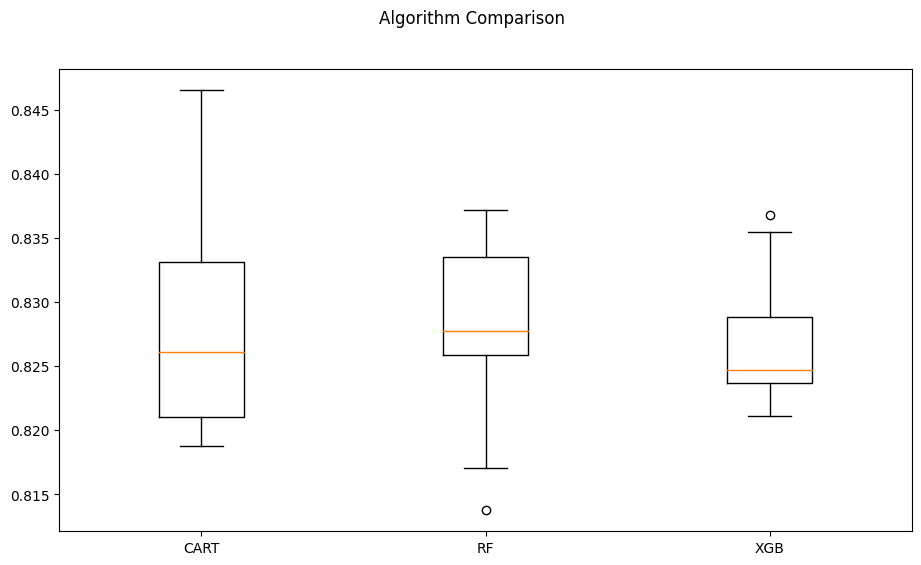

In [36]:
# to feed the random state
seed = 7

# prepare models
models = []
#models.append(('LR', LogisticRegression()))
#models.append(('LDA', LinearDiscriminantAnalysis()))
#models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
#models.append(('NB', GaussianNB()))
models.append(('RF', RandomForestClassifier()))
#models.append(('SVM', SVC(gamma='auto')))
models.append(('XGB', XGBClassifier()))

# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
#scoring = 'recall'
for name, model in models:
        kfold = KFold(n_splits=10, shuffle=True, random_state=seed,)
        cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)

# boxplot algorithm comparison
fig = plt.figure(figsize=(11,6))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [37]:
np.where(np.isnan(X_train)) #X_train.isna().any()

(array([], dtype=int64), array([], dtype=int64))

##Causal Machine Learning

In [38]:
import dowhy
from dowhy import CausalModel

In [39]:
# Simulate some credit risk data
np.random.seed(42)
n = 1000
X = np.random.normal(0, 1, size=(n, 3))  # 3 features: credit score, income, loan amount
T = np.random.binomial(1, p=0.5, size=(n,))  # Treatment: 0 (low interest rate), 1 (high interest rate)
Y = (X[:, 0] * 0.8 - X[:, 1] * 0.3 + T * 1.5 + np.random.normal(0, 1, size=n)) > 0  # Outcome: default or not
data = pd.DataFrame(np.column_stack([X, T, Y]), columns=["credit_score", "income", "loan_amount", "interest_rate", "default"])

In [40]:
data.head()

,credit_score,income,loan_amount,interest_rate,default
0,0.496714,-0.138264,0.647689,1.0,1.0
1,1.523030,-0.234153,-0.234137,1.0,1.0
2,1.579213,0.767435,-0.469474,0.0,1.0
3,0.542560,-0.463418,-0.465730,1.0,1.0
4,0.241962,-1.913280,-1.724918,0.0,1.0


In [41]:
data['interest_rate'].unique()

array([1., 0.])

In [42]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 29 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      32581 non-null  int64  
 1   person_income                   32581 non-null  float64
 2   person_emp_length               32581 non-null  float64
 3   loan_amnt                       32581 non-null  float64
 4   loan_int_rate                   32581 non-null  float64
 5   loan_status                     32581 non-null  int64  
 6   loan_percent_income             32581 non-null  float64
 7   cb_person_cred_hist_length      32581 non-null  int64  
 8   OTHER_DEBT                      32581 non-null  float64
 9   TIME_WITH_BANK                  32581 non-null  int64  
 10  LOAN_PERIOD in days             32581 non-null  float64
 11  person_home_ownership_MORTGAGE  32581 non-null  float64
 12  person_home_ownership_OTHER     

In [43]:
# Define the SCM using DoWhy and specify the causal graph
common_causes=["person_age","person_income", "OTHER_DEBT", "person_emp_length",
                "loan_amnt","loan_percent_income","loan_status", "cb_person_cred_hist_length",
                "TIME_WITH_BANK", "LOAN_PERIOD in days","person_home_ownership_MORTGAGE",
                "person_home_ownership_OTHER","person_home_ownership_OWN","person_home_ownership_RENT",
                "loan_intent_DEBTCONSOLIDATION","loan_intent_EDUCATION","loan_intent_HOMEIMPROVEMENT",
                "loan_intent_MEDICAL","loan_intent_PERSONAL","loan_intent_VENTURE","loan_grade_A",
                "loan_grade_B","loan_grade_C","loan_grade_D","loan_grade_E","loan_grade_F","loan_grade_G"]

model = CausalModel(
    data=df,
    treatment="loan_int_rate",
    outcome="cb_person_default_on_file_N",
    common_causes=common_causes,
    instruments=None  # You can add instruments for IV methods
)

# Identify causal effect
identified_estimand = model.identify_effect()

# Estimate the effect using propensity score matching
estimate = model.estimate_effect(identified_estimand, method_name= "backdoor.linear_regression") #"backdoor.propensity_score_matching")
print("Estimated Causal Effect:", estimate.value)

Estimated Causal Effect: 0.00024275371108217758


Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


##GES algorithm:
This is a score-based algorithm that searches for the causal graph that best fits the data according to a scoring function.

In [45]:
!pip install --force-reinstall pgmpy==0.1.18

  Using cached pgmpy-0.1.18-py3-none-any.whl.metadata (6.3 kB)
  Using cached networkx-3.3-py3-none-any.whl.metadata (5.1 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 3.6 MB/s eta 0:00:00
  Using cached scikit_learn-1.5.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (13 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 5.9 MB/s eta 0:00:00
  Using cached pyparsing-3.1.4-py3-none-any.whl.metadata (5.1 kB)
  Using cached tqdm-4.66.5-py3-none-any.whl.metadata (57 kB)
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached pytz-2024.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2024.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached threadpoolctl-3.5.0-py3-none-any.whl.metadata (13 kB)
  Using cached patsy-0.5.6-py2.py3-none-any.whl.metadata (3.5 kB)
  Using cached packaging-24.1-py3-none-any.whl.metadata (3.2 kB)
 

In [1]:
from pgmpy.estimators import GES
from pgmpy.models import BayesianNetwork

ModuleNotFoundError: No module named 'pgmpy'

In [44]:
# Install the necessary library
!pip install pgmpy==0.1.18

# Import the necessary libraries
from pgmpy.estimators import GES
from pgmpy.models import BayesianNetwork

# Initialize the GES estimator
ges = GES(data=df)

# Estimate the causal graph using the GES algorithm
estimated_model = ges.estimate()

# Print the estimated causal graph
print(estimated_model.edges())

# Create a Bayesian Network from the estimated model
model = BayesianNetwork(estimated_model.edges())

# Fit the Bayesian Network to the data
model.fit(df)

ImportError: cannot import name 'GES' from 'pgmpy.estimators' (/usr/local/lib/python3.10/dist-packages/pgmpy/estimators/__init__.py)

In [ ]:
causal_model = gcm.InvertibleStructuralCausalModel(nx.DiGraph([('loan_amnt', 'loan_int_rate'), ('loan_int_rate', 'cb_person_default_on_file_N')])) # X -> Y -> Z
gcm.auto.assign_causal_mechanisms(causal_model, df)
model.view_model()
gcm.fit(causal_model, df)

##Intervention
Finally, let’s perform an intervention on X. Here, we explicitly perform the intervention
: X=1

In [ ]:
#Interventions

samples = gcm.interventional_samples(causal_model,
                                     {'loan_amount': lambda loan_amount: 1},
                                     num_samples_to_draw=500)
samples.head(2)

In [ ]:
samples = gcm.interventional_samples(causal_model,
                                     {'loan_amount': lambda loan_amount: loan_amount + 0.5},
                                     num_samples_to_draw=500)
samples.head(2)

In [ ]:
#Counterfactuals
gcm.counterfactual_samples(
    causal_model,
    {'loan_amount': lambda loan_amount: 50},
    observed_data=pd.DataFrame(data=dict(loan_amount=[52], interest_rate=[5], default=[0])))

In [ ]:
# Step 3: Causal ML Techniques - Training Causal ML Models
def train_causal_ml_model(X_train, y_train, CreditRiskDataset):
    # Using DoWhy for causal inference
    # Define the causal model
    causal_model = CausalModel(
        CreditRiskDataset=CreditRiskDataset,
        treatment="treatment",  # Placeholder; adjust as needed
        outcome="outcome",  # Placeholder; adjust as needed
        common_causes=["common_cause1", "common_cause2"]  # Placeholder; adjust as needed
    )
    # Identify causal effect
    identified_estimand = causal_model.identify_effect()
    # Estimate the causal effect
    causal_estimate = causal_model.estimate_effect(identified_estimand)
    return causal_estimate

In [ ]:
# Step 4: Performance Evaluation
def evaluate_model(model, X_test, y_test):
    # Using accuracy and F1-score for evaluation
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)
    return accuracy, f1

In [ ]:
# Step 5: Main Execution Workflow
def main():
    # Load Data (placeholder for actual dataset)
    # The raw link to the CSV file in the GitHub repository
    url = 'https://raw.githubusercontent.com/dzrich/PhD_Research_in_CausalML/main/Data/CreditRiskDataset.csv'

    # Load the CSV file into a pandas DataFrame
    CreditRiskDataset = pd.read_csv(url)


    # Data Engineering
    X, y = data_engineering(CreditRiskDataset)

    # Split Data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train Correlational ML Model
    corr_model = train_corr_ml_model(X_train, y_train)
    corr_accuracy, corr_f1 = evaluate_model(corr_model, X_test, y_test)
    print(f"Correlational Model Accuracy: {corr_accuracy}, F1-Score: {corr_f1}")
if __name__ == "__main__":
    main()


In [ ]:
print(X_train.head(5))


In [ ]:
 # Train Causal ML Model (Placeholder - actual implementation depends on data specifics)
    causal_estimate = train_causal_ml_model(X_train, y_train, CreditRiskDataset)
    print(f"Causal Estimate: {causal_estimate.value}")

    # Generalizability Check (Example Decision Logic)
    if corr_accuracy > 0.8:  # Threshold for generalizability - adjust based on context
        print("Correlational ML Model is generalizable. Deploying...")
    elif causal_estimate.value > 0.1:  # Example threshold for causal model
        print("Causal ML Model is generalizable. Deploying...")
    else:
        print("Models are not generalizable. Reiterate data engineering or model training steps.")

if __name__ == "__main__":
    main()

https://github.com/dzrich/PhD_Research_in_CausalML/tree/main/Data